In [8]:
import os
import sys

import utils.train_utils

sys.path.append('../../src')
import copy
import numpy as np

from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample
from model.loss import spectral_loss
from synth.synth_architecture import SynthModular
from main_hp_search_dec_only import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants
from utils.visualization_utils import  calc_loss_vs_param_range, plot_loss_vs_param
from utils.train_utils import to_torch_recursive

import matplotlib
matplotlib.pyplot.ion()

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Setup experiment
project_root = r'/home/almogelharar/almog/ai_synth'

exp_name = 'loss_surface_visualization_fm_saw'
dataset_name = 'lfo_saw_single'
device = 'cpu'

config_path = os.path.join(project_root, 'configs', 'optimization_analysis', 'lfo_saw_single_synth_config_hp_search.yaml')
data_path = os.path.join(project_root, 'data', dataset_name, 'train', '')

cfg = configure_experiment(exp_name, dataset_name, config_path, debug=True)

synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

dataset = AiSynthDataset(data_path, noise_std=0)

In [12]:
target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

target_param_dict = to_torch_recursive(target_param_dict, device, ignore_dtypes=(str, tuple))

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(1, 1): {'operation': 'lfo', 'parameters': {'active': tensor([True]), 'output': tensor([[0, 2]]), 'freq': tensor([14.6300]), 'waveform': 'square'}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': tensor([1], dtype=torch.int32), 'active': tensor([True]), 'amp_c': tensor([0.3839]), 'freq_c': tensor([1479.9777]), 'mod_index': tensor([0.0820])}}}


In [13]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants,
                                          device=device)

In [17]:
params_to_visualize = [{'param_name': 'freq_c', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 2000, 'n_steps': 2000},
                       {'param_name': 'amp_c', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'mod_index', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 0.3, 'n_steps': 300},
                       {'param_name': 'freq', 'cell_index': (1, 1), 'min_val': 0, 'max_val': 20, 'n_steps': 1000}]

100%|█████████████████████████████████████████████████████████████████████| 2000/2000 [01:35<00:00, 21.00it/s]


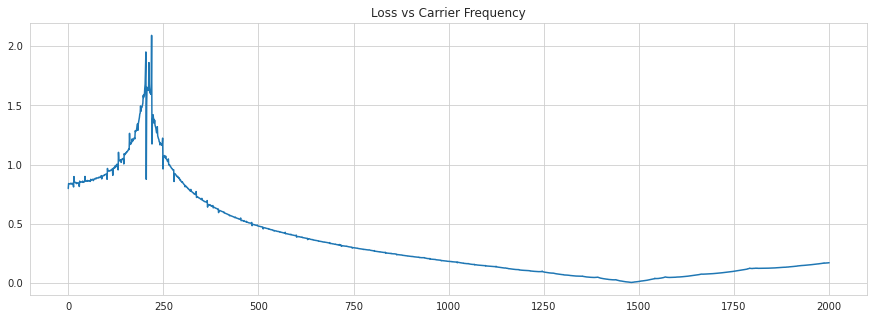

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.86it/s]


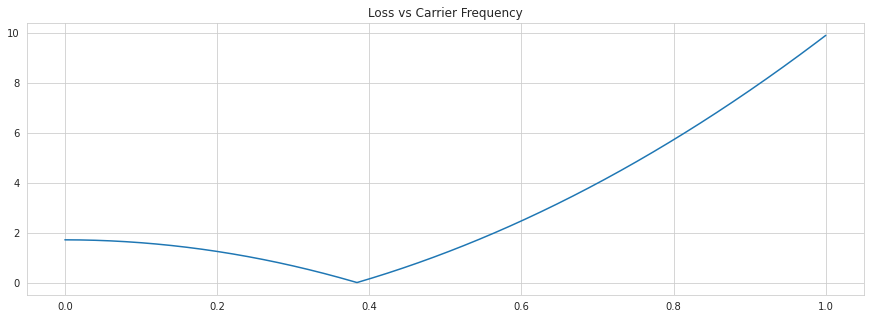

 34%|███████████████████████▉                                               | 101/300 [00:06<00:13, 14.62it/s]

KeyboardInterrupt



In [18]:
for param_to_visualize in params_to_visualize:
    loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler, **param_to_visualize)
    plot_loss_vs_param(param_range, loss_vals, title=f'Loss vs {param_to_visualize["param_name"]}')